# A numerical study of fixation probabilities for strategies in the Prisoners  Dilemma

This notebook contains all the Python code used to generate the plots and figures for the paper.

Here are the versions of the various libraries used:

In [431]:
%matplotlib inline

import axelrod as axl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import imp
players = imp.load_source('players', '../src/players.py')
generate_cache = imp.load_source('players', '../src/generate_cache.py')
theoretic = imp.load_source('theoretic', '../src/theoretic.py')

assert axl.__version__ == '2.9.0' 
assert pd.__version__ == '0.19.2'
assert matplotlib.__version__ == '2.0.0'
assert sns.__version__ == '0.7.1'
assert np.__version__ == '1.12.1'

## Description of the used strategies

Here are all the strategies used in this experiment:

In [432]:
from players import selected_players
players = selected_players()

assert len(players) == 172

In [433]:
players

[Adaptive,
 Adaptive Tit For Tat: 0.5,
 Aggravater,
 ALLCorALLD,
 Alternator,
 Alternator Hunter,
 AntiCycler,
 Anti Tit For Tat,
 Adaptive Pavlov 2006,
 Adaptive Pavlov 2011,
 Appeaser,
 Arrogant QLearner,
 Average Copier,
 Better and Better,
 BackStabber: ('D', 'D'),
 Bully,
 Calculator,
 Cautious QLearner,
 Champion,
 CollectiveStrategy,
 Contrite Tit For Tat,
 Cooperator,
 Cooperator Hunter,
 Cycle Hunter,
 Cycler CCCCCD,
 Cycler CCCD,
 Cycler CCD,
 Cycler DC,
 Cycler DDC,
 Cycler CCCDCD,
 Davis: 10,
 Defector,
 Defector Hunter,
 Desperate,
 DoubleCrosser: ('D', 'D'),
 Doubler,
 EasyGo,
 Eatherley,
 Eventual Cycle Hunter,
 Evolved ANN,
 Evolved ANN 5,
 Evolved ANN 5 Noise 05,
 Evolved FSM 4,
 Evolved FSM 16,
 Evolved FSM 16 Noise 05,
 EvolvedLookerUp1_1_1,
 EvolvedLookerUp2_2_2,
 Evolved HMM 5,
 Feld: 1.0, 0.5, 200,
 Firm But Fair,
 Fool Me Forever,
 Fool Me Once,
 Forgetful Fool Me Once: 0.05,
 Forgetful Grudger,
 Forgiver,
 Forgiving Tit For Tat,
 Fortress3,
 Fortress4,
 GTFT: 0.

In [434]:
with open("../tbl/list_of_players.tex", "w") as f:
    for player in players:
        latex_name = "{}\n".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))

Here are some summary information about the strategies

In [435]:
def clean_mem(n):
    try:
        return int(n)
    except OverflowError:
        return -1

df = pd.DataFrame([[p, p.classifier["stochastic"], clean_mem(p.classifier['memory_depth'])] 
                   for p in players], 
                  columns=["Player", "Stochastic", "Memory Depth"])

In [436]:
t_df = pd.DataFrame(df.groupby("Stochastic")["Player"].count()).reset_index().rename(columns={"Player": "Count"})
t_df

,Stochastic,Count
0,False,123
1,True,49


In [437]:
with open("../tbl/stochastic_count.tex", "w") as f:
    f.write(t_df.to_latex(index=False))

In [438]:
t_df = pd.DataFrame(df.groupby("Memory Depth")["Player"].count()).transpose()
t_df.rename(index={"Player": "Count"}, inplace=True)
cols = t_df.columns.tolist()
t_df = t_df[cols[1:] + [cols[0]]]
t_df

Memory Depth,0,1,2,3,4,5,6,9,10,11,12,16,20,40,200,-1
Count,3,31,12,8,2,6,1,1,5,1,1,2,2,2,1,94


In [439]:
with open("../tbl/memory_depth_count.tex", "w") as f:
    string = t_df.to_latex().replace("-1", "\(\infty\)")
    f.write(string)

## Illustrating the Approximate moran process

In [440]:
df = pd.read_csv("../data/outcomes.csv", header=None, names=["Player 1", "Player 2", 
                                                             "Score 1", "Score 2", 
                                                             "Iteration"])

Get the counts of each number of 

In [441]:
t_df = pd.DataFrame(df.groupby(["Player 1", "Player 2"]).count()).reset_index()

In [442]:
max_pair = t_df.iloc[t_df["Score 1"].idxmax()][:2]
max_pair

Player 1            Risky QLearner
Player 2    Meta Hunter: 6 players
Name: 13103, dtype: object

In [443]:
min_pair = t_df.iloc[t_df["Score 1"].idxmin()][:2]
min_pair

Player 1    $\phi$
Player 2    $\phi$
Name: 0, dtype: object

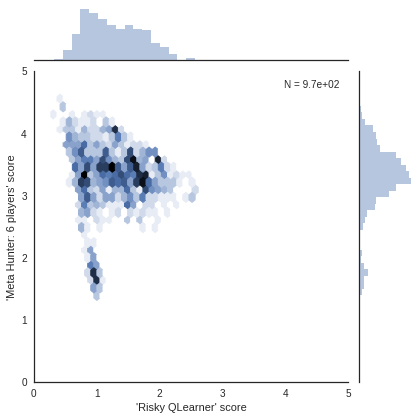

In [444]:
t_df = df[(df["Player 1"] == max_pair[0]) & (df["Player 2"] == max_pair[1])]

def N(x, y):
    return len(x)

sns.set(style="white", color_codes=True)
ax = sns.jointplot(t_df["Score 1"], t_df["Score 2"], stat_func=N, 
                   kind="hex", xlim=(0, 5), ylim=(0,5))
ax.set_axis_labels(*["\'{}\' score".format(max_pair[i][:25]) for i in range(2)])
ax.savefig("../img/players_with_most_scores.pdf");

In [445]:
len(t_df["Score 1"])

971

## Validating the model

Here we create a number of plots comparing the theoretic fixation probability with the observed fixation probability.

In [446]:
df = pd.read_csv("../data/fixation_validation.csv")

/home/vince/anaconda3/envs/moran/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


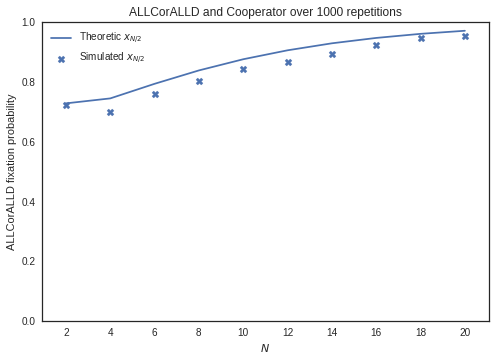

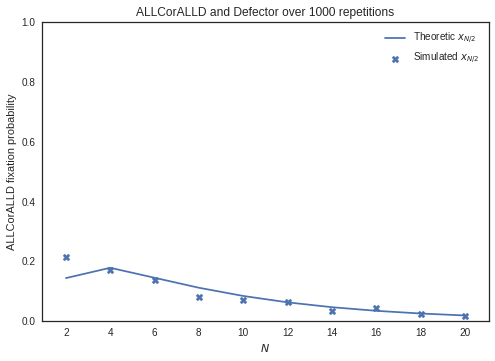

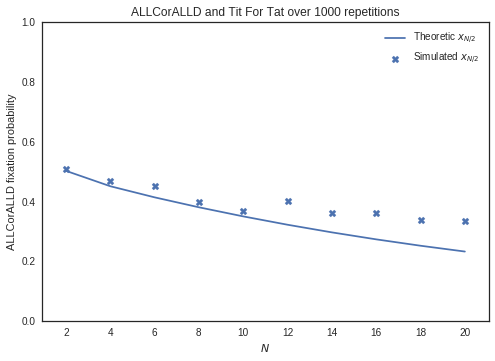

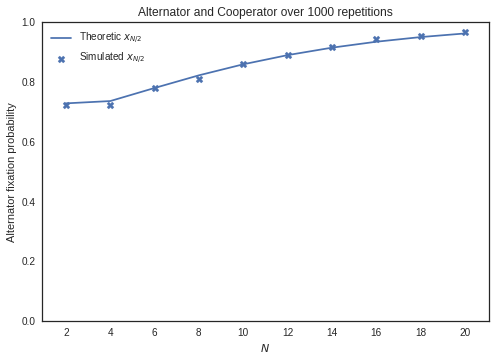

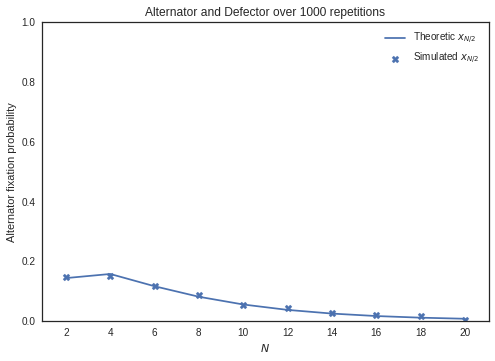

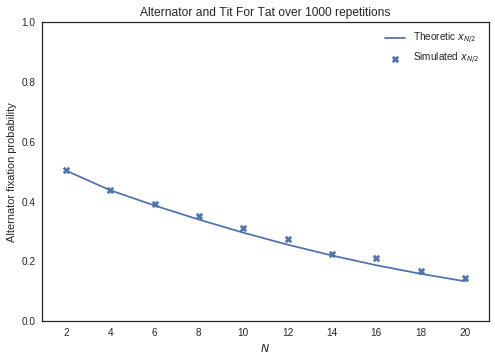

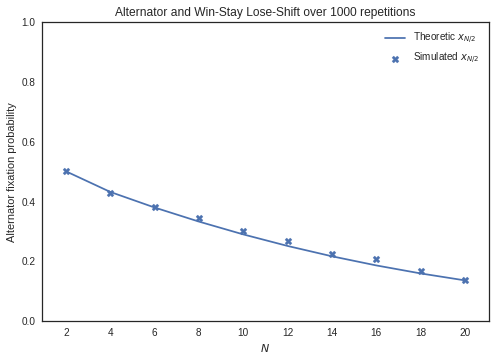

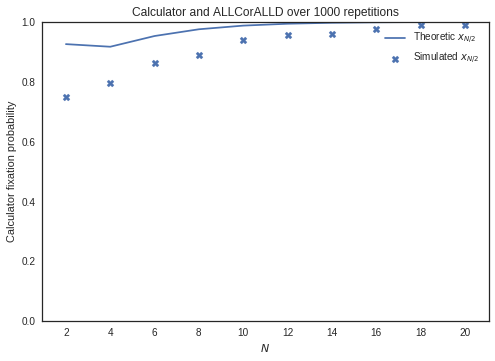

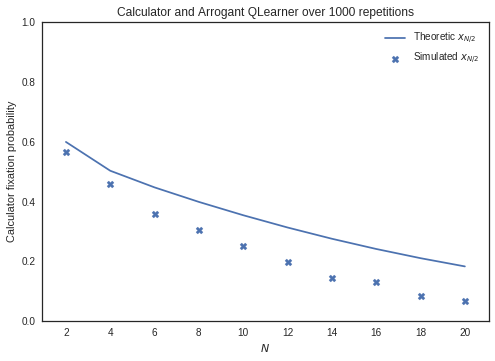

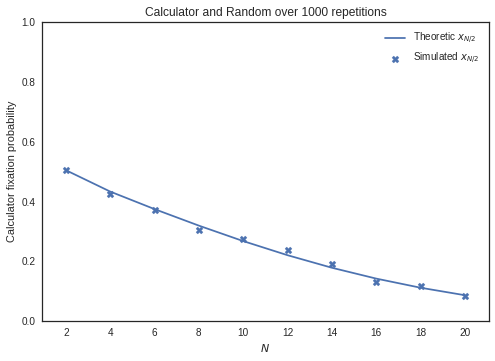

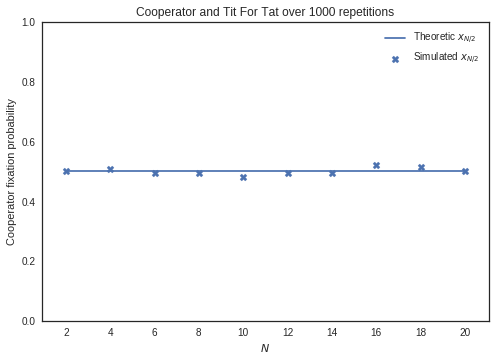

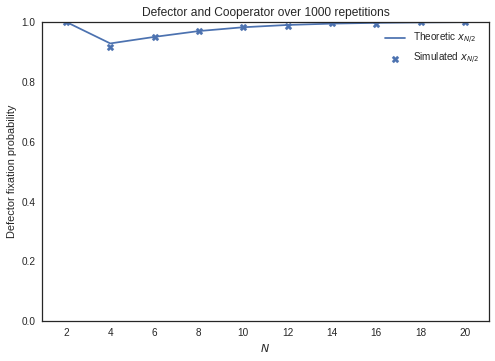

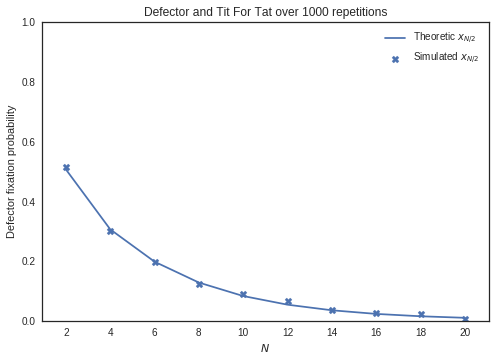

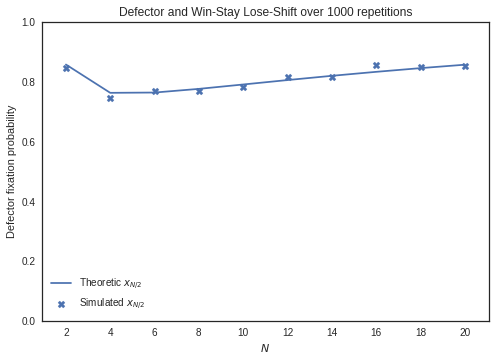

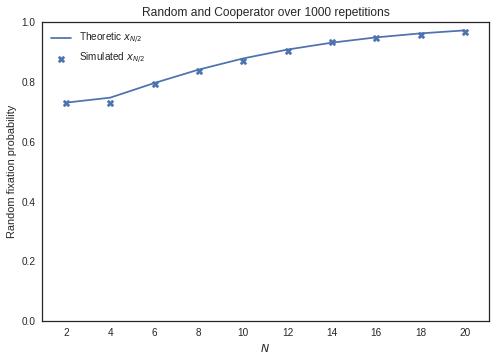

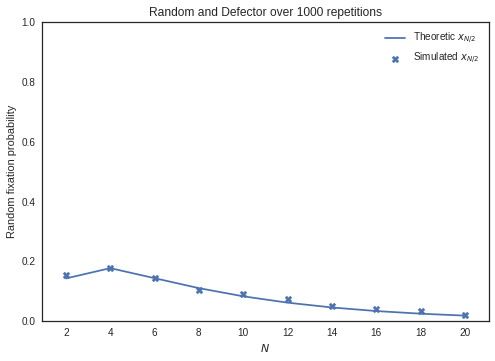

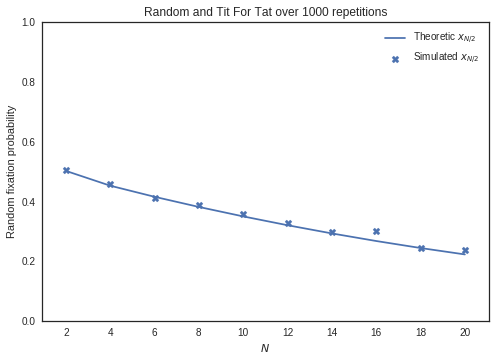

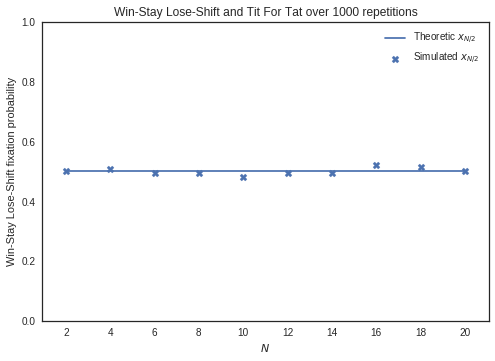

In [447]:
all_player_names = [p.__repr__() for p in players]
for names, player_pair_df in df.groupby(["Player 1", "Player 2"]):
    
    player_pair_df.sort_values("N", inplace=True)
    
    repetitions = player_pair_df["Repetitions"].iloc[0]
    assert all(player_pair_df["Repetitions"] == repetitions)
    
    # Get names instead of repr (to drop some parameters)
    names = [players[all_player_names.index(name)].name 
             for name in names]
    title = "{} and {} over {} repetitions".format(*names, repetitions)
    filename = "{}_v_{}".format(*names)

    for substr in [": ", ".", ":", " "]:
        filename = filename.replace(substr, "_")
    
    plt.figure()
    plt.plot(player_pair_df["N"], player_pair_df["Theoretic"], label="Theoretic $x_{N/2}$")
    plt.scatter(player_pair_df["N"], player_pair_df["Simulated"], label="Simulated $x_{N/2}$",
                marker="X")
    plt.xticks(player_pair_df["N"])
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel("{} fixation probability".format(names[0]))
    plt.xlabel("$N$")
    plt.legend()
    plt.savefig("../img/{}.pdf".format(filename))

# Carry out analysis of Moran processes

In [448]:
df = pd.read_csv("../data/sims_summary.csv")

In [449]:
df.head()

,P1,P2,N,Noise,Repetitions,P1 fixation,P2 fixation
0,$\phi$,Adaptive Pavlov 2006,2,False,2000,0.4730,0.5270
1,$\phi$,Adaptive Pavlov 2006,2,True,2000,0.4670,0.5330
2,$\phi$,Adaptive Pavlov 2006,4,False,2000,0.4150,0.5850
3,$\phi$,Adaptive Pavlov 2006,4,True,2000,0.4985,0.5015
4,$\phi$,Adaptive Pavlov 2006,6,False,2000,0.3745,0.6255


### Median fixation probability for each strategy

In [450]:
fix_df = pd.concat([df[["P1", "P1 fixation", "N", "Noise"]].rename(columns={"P1": "Player", 
                                                                            "P1 fixation": "Fixation"}),
                    df[["P2", "P2 fixation", "N", "Noise"]].rename(columns={"P2": "Player", 
                                                                            "P2 fixation": "Fixation"})])

In [451]:
med_fix = pd.DataFrame(fix_df.groupby(["Player", "N", "Noise"])["Fixation"].median()).reset_index()

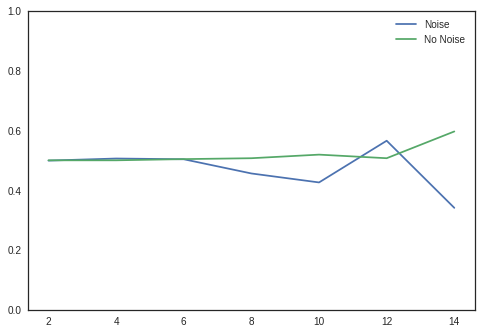

In [452]:
strategy = "Tit For Tat"
plt.figure()
for noise in [True, False]:
    d = med_fix[(med_fix["Player"] == strategy) &
                (med_fix["Noise"] == noise)]
    label = "Noise" if noise else "No Noise"
    plt.plot(d["N"], d["Fixation"], label=label)
    plt.legend()
    plt.ylim(0, 1);